In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchlake.image_generation.controllers.trainer_pixelcnn import PixelCNNTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_generation.models.gated_pixelcnn import GatedPixelCNN
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 28
BATCH_SIZE = 128

In [3]:
artifact_path = Path("../../artifacts/gated-pixelcnn")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/mnist")

In [4]:
DEVICE = torch.device("cuda:0")

In [5]:
NUM_CLASS = 10

# Data

In [6]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [7]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

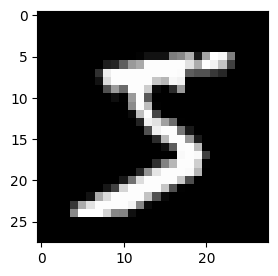

In [ ]:
plt.figure(figsize=(3, 3))
plt.imshow(img_tensor_to_np(train_data[0][0]), cmap="gray")

In [ ]:
def collate_fn(batch):
    x, y = [], []
    for img, _ in batch:
        x.append(img)
        y.append(img)
        
    # B, C, H, W # B*C, H, W
    return torch.stack(x), torch.stack(y).mul_(255).long().view(-1, IMAGE_SIZE, IMAGE_SIZE)

In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=get_num_workers(),
)

In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128, 28, 28])


# Model

In [ ]:
import torchinfo

In [35]:
model = GatedPixelCNN(
    1,
    256,
    hidden_dim=128,
    num_layers=12,
)

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
GatedPixelCNN                            --
├─Sequential: 1-1                        --
│    └─MaskedConv2d: 2-1                 12,800
├─ModuleList: 1-2                        --
│    └─GatedLayer: 2-2                   --
│    │    └─DownwardConv2d: 3-1          98,560
│    │    └─DownwardConv2d: 3-2          49,280
│    │    └─DownwardConv2d: 3-3          49,280
│    │    └─Conv2d: 3-4                  65,792
│    │    └─MaskedConv2d: 3-5            98,560
│    │    └─MaskedConv2d: 3-6            147,584
│    │    └─MaskedConv2d: 3-7            147,584
│    │    └─MaskedConv2d: 3-8            16,512
│    └─GatedLayer: 2-3                   --
│    │    └─DownwardConv2d: 3-9          98,560
│    │    └─DownwardConv2d: 3-10         49,280
│    │    └─DownwardConv2d: 3-11         49,280
│    │    └─Conv2d: 3-12                 65,792
│    │    └─MaskedConv2d: 3-13           98,560
│    │    └─MaskedConv2d: 3-14           147,584
│    │  

# train

In [37]:
EPOCH = 10

In [38]:
trainer = PixelCNNTrainer(EPOCH, DEVICE)

In [39]:
trainer.recorder.increment_data_size(len(train_data))

In [40]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [41]:
scaler = torch.amp.GradScaler()

In [42]:
training_loss = trainer.run(train_loader, model, optim, criterion, scaler=scaler)

Enable AMP: True
Training...


100%|██████████| 468/468 [03:20<00:00,  2.33it/s]


------------------------------------
Epoch 1
------------------------------------
0.007630486119786899 (0%)


100%|██████████| 468/468 [02:46<00:00,  2.81it/s]


------------------------------------
Epoch 2
------------------------------------
0.006474949243664743 (-15%)


100%|██████████| 468/468 [02:44<00:00,  2.85it/s]


------------------------------------
Epoch 3
------------------------------------
0.0063708972622950905 (-2%)


100%|██████████| 468/468 [02:57<00:00,  2.63it/s]


------------------------------------
Epoch 4
------------------------------------
0.006200705760717393 (-3%)


100%|██████████| 468/468 [02:45<00:00,  2.83it/s]


------------------------------------
Epoch 5
------------------------------------
0.006126691174507148 (-1%)


100%|██████████| 468/468 [02:44<00:00,  2.85it/s]


------------------------------------
Epoch 6
------------------------------------
0.006071184368928271 (-1%)


100%|██████████| 468/468 [02:44<00:00,  2.85it/s]


------------------------------------
Epoch 7
------------------------------------
0.006030575658877688 (-1%)


100%|██████████| 468/468 [02:44<00:00,  2.85it/s]


------------------------------------
Epoch 8
------------------------------------
0.006004513075947767 (0%)


100%|██████████| 468/468 [02:44<00:00,  2.85it/s]


------------------------------------
Epoch 9
------------------------------------
0.00595506140093008 (-1%)


100%|██████████| 468/468 [02:43<00:00,  2.86it/s]

------------------------------------
Epoch 10
------------------------------------
0.005897685187061626 (-1%)


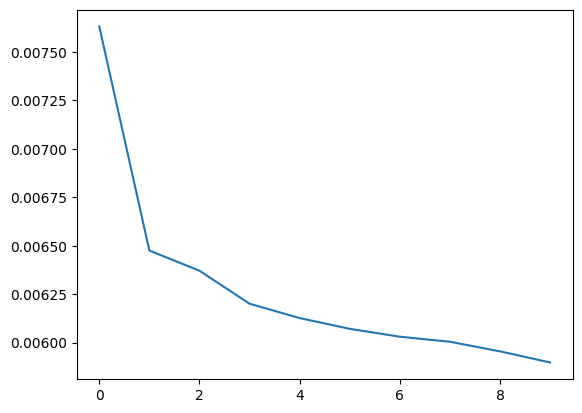

In [43]:
plt.plot(training_loss)

In [44]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('gated-pixelcnn.d{hidden_dim}.l{num_layer}.mnist.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layers)

In [45]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\gated-pixelcnn\gated-pixelcnn.d128.l12.mnist.pth, model size is 31.19MiB


In [46]:
manager.load_weight(model_path, model)

# evaluation

In [47]:
TEST_BATCH_SIZE = 16

784it [00:14, 55.32it/s]


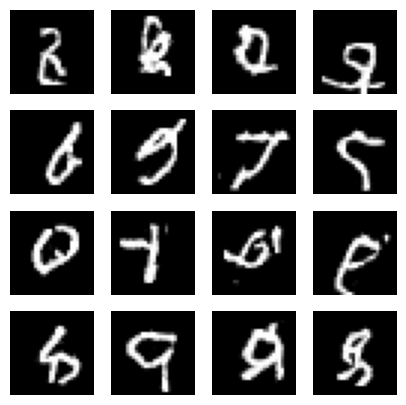

In [48]:
from itertools import product

model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(1))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder[:, :, :(i+1)])[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)

# Conditional 

## data

In [23]:
import torch.nn.functional as F

In [24]:
COND_BATCH_SIZE = 128

In [25]:
def cond_collate_fn(batch):
    x, y, c = [], [], []
    for img, label in batch:
        x.append(img)
        y.append(img)
        c.append(label)
        
    # B, C, H, W # B*C, H, W
    c = torch.LongTensor(c)
    c = F.one_hot(c, NUM_CLASS)
    return torch.stack(x), torch.stack(y).mul_(255).long().view(-1, IMAGE_SIZE, IMAGE_SIZE), c.float()

In [26]:
cond_train_loader = DataLoader(
    train_data,
    batch_size=COND_BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=cond_collate_fn,
    num_workers=get_num_workers(),
)

In [27]:
for x, y, c in cond_train_loader:
    print(x.shape, y.shape, c.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128, 28, 28]) torch.Size([128, 10])


## model

In [28]:
import torchinfo

In [29]:
model = GatedPixelCNN(
    1,
    256,
    hidden_dim=128,
    num_layers=12,
    conditional_shape=(10,),
)

In [30]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
GatedPixelCNN                            --
├─Sequential: 1-1                        --
│    └─MaskedConv2d: 2-1                 12,800
├─ModuleList: 1-2                        --
│    └─GatedLayer: 2-2                   --
│    │    └─DownwardConv2d: 3-1          98,560
│    │    └─DownwardConv2d: 3-2          49,280
│    │    └─DownwardConv2d: 3-3          49,280
│    │    └─Conv2d: 3-4                  65,792
│    │    └─MaskedConv2d: 3-5            98,560
│    │    └─MaskedConv2d: 3-6            147,584
│    │    └─MaskedConv2d: 3-7            147,584
│    │    └─MaskedConv2d: 3-8            16,512
│    │    └─Conv2d: 3-9                  1,408
│    │    └─Conv2d: 3-10                 1,408
│    │    └─Conv2d: 3-11                 1,408
│    │    └─Conv2d: 3-12                 1,408
│    └─GatedLayer: 2-3                   --
│    │    └─DownwardConv2d: 3-13         98,560
│    │    └─DownwardConv2d: 3-14         49,280
│    │    └─D

## train

In [31]:
EPOCH = 10

In [32]:
from typing import Iterable

class ConditionalPixelCNNTrainer(PixelCNNTrainer):
    def _predict(
        self,
        row: tuple[Iterable],
        model: nn.Module,
        *args,
        **kwargs,
    ):
        x, _, c = row
        x = x.to(self.device)
        c = c.to(self.device)

        return model(x, cond=c, *args, **kwargs)
    
    def _calc_loss(
        self,
        y_hat: torch.Tensor,
        row: tuple[Iterable],
        criterion: nn.Module,
    ) -> torch.Tensor:
        _, y, _ = row
        y: torch.Tensor = y.to(self.device)

        # B, C, 256, H, W => B*C, 256, H, W
        return criterion(y_hat.view(-1, *y_hat.shape[2:]), y.long())

In [33]:
trainer = ConditionalPixelCNNTrainer(EPOCH, DEVICE)

In [34]:
trainer.recorder.increment_data_size(len(train_data))

In [35]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [36]:
scaler = torch.amp.GradScaler()

In [37]:
training_loss = trainer.run(cond_train_loader, model, optim, criterion, scaler=scaler)

Enable AMP: True
Training...


100%|██████████| 468/468 [03:03<00:00,  2.55it/s]


------------------------------------
Epoch 1
------------------------------------
0.007590450007716821 (0%)


100%|██████████| 468/468 [03:01<00:00,  2.58it/s]


------------------------------------
Epoch 2
------------------------------------
0.006353278232614194 (-16%)


100%|██████████| 468/468 [03:00<00:00,  2.60it/s]


------------------------------------
Epoch 3
------------------------------------
0.006156977339585628 (-3%)


100%|██████████| 468/468 [03:01<00:00,  2.58it/s]


------------------------------------
Epoch 4
------------------------------------
0.006063102267185848 (-2%)


100%|██████████| 468/468 [03:03<00:00,  2.54it/s]


------------------------------------
Epoch 5
------------------------------------
0.005989552144209543 (-1%)


100%|██████████| 468/468 [03:04<00:00,  2.53it/s]


------------------------------------
Epoch 6
------------------------------------
0.00593147485852241 (-1%)


100%|██████████| 468/468 [03:06<00:00,  2.51it/s]


------------------------------------
Epoch 7
------------------------------------
0.005865189708272612 (-1%)


100%|██████████| 468/468 [03:07<00:00,  2.50it/s]


------------------------------------
Epoch 8
------------------------------------
0.006350846583644552 (8%)


100%|██████████| 468/468 [03:07<00:00,  2.50it/s]


------------------------------------
Epoch 9
------------------------------------
0.006168297344446186 (-3%)


100%|██████████| 468/468 [03:07<00:00,  2.50it/s]

------------------------------------
Epoch 10
------------------------------------
0.006043561889727913 (-2%)


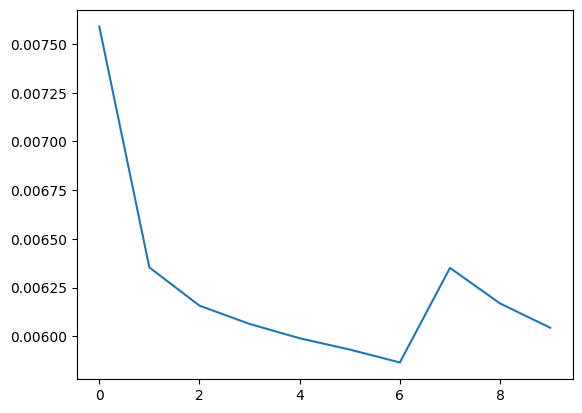

In [38]:
plt.plot(training_loss)

In [39]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('gated-pixelcnn.d{hidden_dim}.l{num_layer}.mnist.cond.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layers)

In [40]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\gated-pixelcnn\gated-pixelcnn.d128.l12.mnist.cond.pth, model size is 31.48MiB


In [41]:
manager.load_weight(model_path, model)

## evaluation

In [42]:
TEST_BATCH_SIZE = 16

## unconditional (conditional trained)

784it [00:18, 42.67it/s]


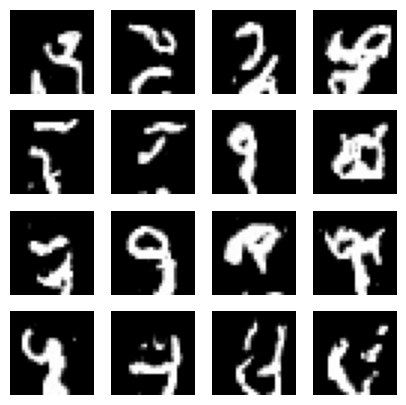

In [43]:
from itertools import product

model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(1))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder[:, :, :(i+1)])[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)

## conditional

784it [00:23, 33.79it/s]


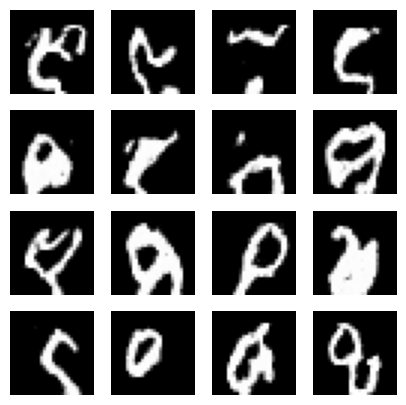

In [56]:
from itertools import product

model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    cond = F.one_hot(torch.full((TEST_BATCH_SIZE,), 0), NUM_CLASS).float().to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(1))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder[:, :, :(i+1)], cond=cond)[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)

784it [00:26, 29.85it/s]


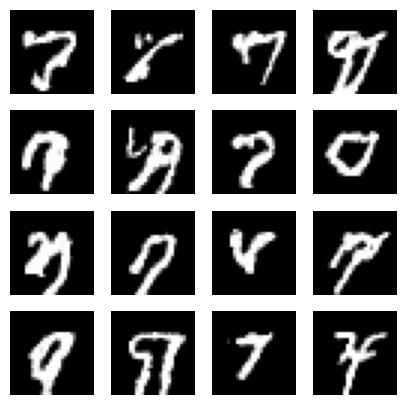

In [53]:
from itertools import product

model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    cond = F.one_hot(torch.full((TEST_BATCH_SIZE,), 7), NUM_CLASS).float().to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(1))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder[:, :, :(i+1)], cond=cond)[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)

784it [00:21, 36.50it/s]


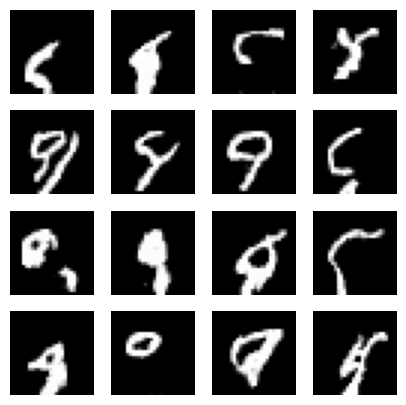

In [55]:
from itertools import product

model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    cond = F.one_hot(torch.full((TEST_BATCH_SIZE,), 9), NUM_CLASS).float().to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(1))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder[:, :, :(i+1)], cond=cond)[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)